In [8]:
import numpy as np

import matplotlib
%matplotlib inline

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

import sys
sys.path.append('../code')
from run_inference import load_inference_results, print_inference_summary, load_likelihood_grid

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# Use serif font (will automatically pick an available serif font)
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Bitstream Vera Sans']
matplotlib.rcParams['text.usetex'] = False
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['figure.figsize'] = (16.0, 10.0)
matplotlib.rcParams['axes.unicode_minus'] = False

# Suppress font warnings
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib.font_manager')

## Visualize Processed Pixelized Catalogs

Loading catalogs from:
  Galaxy file: ../data/mocks_glass/mock_seed42_ratioNgalNagn1_bgal1.0_bagn1.0/lognormal_pixelated_nside_64_galaxies.h5
  AGN file: ../data/mocks_glass/mock_seed42_ratioNgalNagn1_bgal1.0_bagn1.0/lognormal_pixelated_nside_64_agn.h5



Galaxy catalog:
  Shape: (49152, 350)
  Total galaxies: 1176983
  Pixels with galaxies: 49152
  Max galaxies per pixel: 45
  Mean galaxies per pixel: 23.9

AGN catalog:
  Shape: (49152, 350)
  Total AGN: 1177354
  Pixels with AGN: 49152
  Max AGN per pixel: 47
  Mean AGN per pixel: 24.0


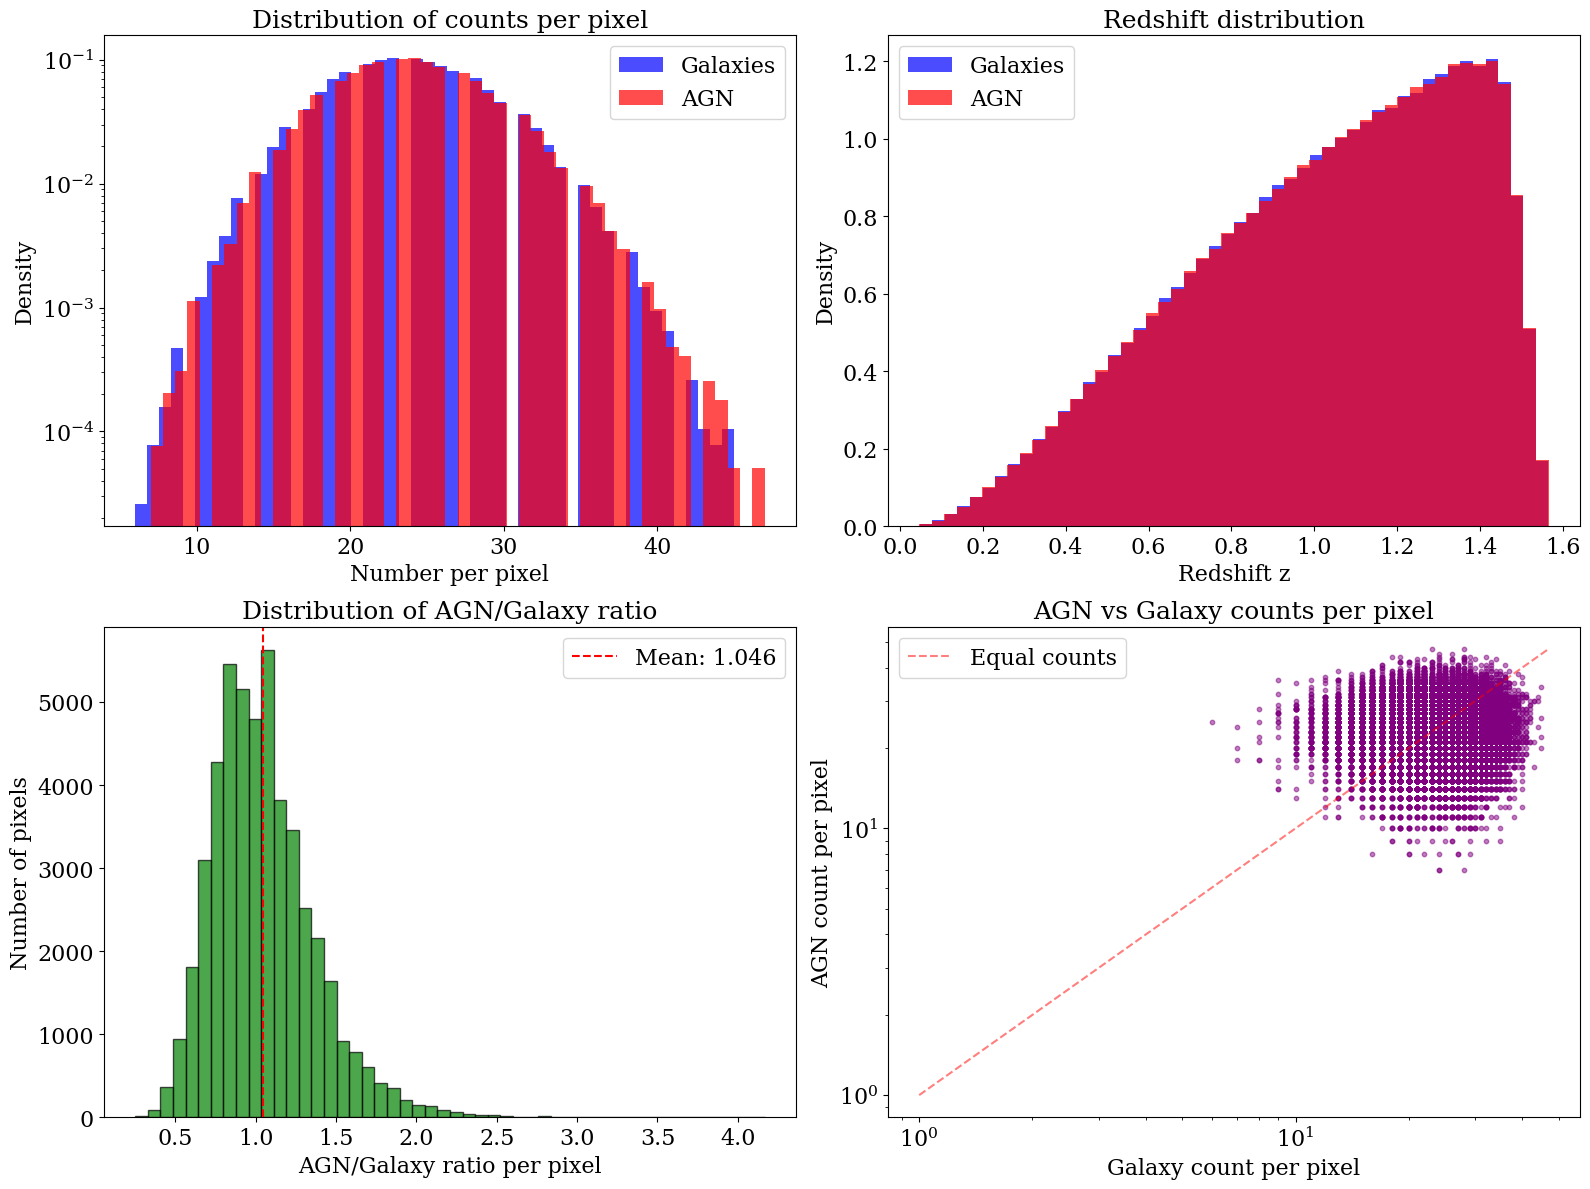

In [21]:
# Load and visualize the processed pixelized catalogs
import h5py
import healpy as hp

# Set up paths
ratioNgalNagn = 1
bias_gal = 1.0
bias_agn = 1.0
seed = 42
nside = 64

tag_mock_extra = f'_bgal{bias_gal}_bagn{bias_agn}'
tag_mock = f'_seed{seed}_ratioNgalNagn{ratioNgalNagn}{tag_mock_extra}'
dir_mock = f'../data/mocks_glass/mock{tag_mock}'
galaxy_file = os.path.join(dir_mock, f'lognormal_pixelated_nside_{nside}_galaxies.h5')
agn_file = os.path.join(dir_mock, f'lognormal_pixelated_nside_{nside}_agn.h5')

print(f"Loading catalogs from:")
print(f"  Galaxy file: {galaxy_file}")
print(f"  AGN file: {agn_file}")

# Load catalog data
with h5py.File(galaxy_file, 'r') as f:
    zgals = np.array(f['zgals'])
    ngals = np.array(f['ngals'])
    print(f"\nGalaxy catalog:")
    print(f"  Shape: {zgals.shape}")
    print(f"  Total galaxies: {ngals.sum()}")
    print(f"  Pixels with galaxies: {(ngals > 0).sum()}")
    print(f"  Max galaxies per pixel: {ngals.max()}")
    print(f"  Mean galaxies per pixel: {ngals[ngals > 0].mean():.1f}")

with h5py.File(agn_file, 'r') as f:
    zagns = np.array(f['zagn'])
    nagns = np.array(f['nagn'])
    print(f"\nAGN catalog:")
    print(f"  Shape: {zagns.shape}")
    print(f"  Total AGN: {nagns.sum()}")
    print(f"  Pixels with AGN: {(nagns > 0).sum()}")
    print(f"  Max AGN per pixel: {nagns.max()}")
    print(f"  Mean AGN per pixel: {nagns[nagns > 0].mean():.1f}")

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Increase font sizes
fontsize = 16
title_fontsize = 18

# 1. Count distribution per pixel
ax = axes[0, 0]
ax.hist(ngals[ngals > 0], bins=50, alpha=0.7, label='Galaxies', color='blue', density=True)
ax.hist(nagns[nagns > 0], bins=50, alpha=0.7, label='AGN', color='red', density=True)
ax.set_xlabel('Number per pixel', fontsize=fontsize)
ax.set_ylabel('Density', fontsize=fontsize)
ax.set_title('Distribution of counts per pixel', fontsize=title_fontsize)
ax.legend(fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
ax.set_yscale('log')

# 2. Redshift distribution
ax = axes[0, 1]
# Extract valid redshifts (not 100)
valid_zgals = zgals[zgals != 100]
valid_zagns = zagns[zagns != 100]
ax.hist(valid_zgals, bins=50, alpha=0.7, label='Galaxies', color='blue', density=True)
ax.hist(valid_zagns, bins=50, alpha=0.7, label='AGN', color='red', density=True)
ax.set_xlabel('Redshift z', fontsize=fontsize)
ax.set_ylabel('Density', fontsize=fontsize)
ax.set_title('Redshift distribution', fontsize=title_fontsize)
ax.legend(fontsize=fontsize)
ax.tick_params(labelsize=fontsize)

# 3. Ratio of AGN to galaxies per pixel
ax = axes[1, 0]
mask = ngals > 0
ratio = np.zeros_like(ngals, dtype=float)
ratio[mask] = nagns[mask] / ngals[mask]
ratio[~mask] = np.nan
ax.hist(ratio[mask], bins=50, alpha=0.7, color='green', edgecolor='black')
ax.set_xlabel('AGN/Galaxy ratio per pixel', fontsize=fontsize)
ax.set_ylabel('Number of pixels', fontsize=fontsize)
ax.set_title('Distribution of AGN/Galaxy ratio', fontsize=title_fontsize)
ax.axvline(ratio[mask].mean(), color='red', linestyle='--', label=f'Mean: {ratio[mask].mean():.3f}')
ax.legend(fontsize=fontsize)
ax.tick_params(labelsize=fontsize)

# 4. Scatter plot: AGN vs Galaxy counts per pixel
ax = axes[1, 1]
ax.scatter(ngals, nagns, alpha=0.5, s=10, c='purple')
ax.set_xlabel('Galaxy count per pixel', fontsize=fontsize)
ax.set_ylabel('AGN count per pixel', fontsize=fontsize)
ax.set_title('AGN vs Galaxy counts per pixel', fontsize=title_fontsize)
ax.set_xscale('log')
ax.set_yscale('log')
# Add diagonal line for equal counts
max_val = max(ngals.max(), nagns.max())
ax.plot([1, max_val], [1, max_val], 'r--', alpha=0.5, label='Equal counts')
ax.legend(fontsize=fontsize)
ax.tick_params(labelsize=fontsize)

plt.tight_layout()
plt.show()

# Print some statistics
# print(f"\nCatalog comparison:")
# print(f"  Pixels with both AGN and galaxies: {both_mask.sum()}")
# print(f"  Pixels with only galaxies: {((ngals > 0) & (nagns == 0)).sum()}")
# print(f"  Pixels with only AGN: {((ngals == 0) & (nagns > 0)).sum()}")
# print(f"  Empty pixels: {((ngals == 0) & (nagns == 0)).sum()}")
# print(f"\n  Mean AGN/Galaxy ratio (where galaxies > 0): {ratio_map[mask].mean():.3f}")
# print(f"  Median AGN/Galaxy ratio (where galaxies > 0): {np.nanmedian(ratio_map[mask]):.3f}")

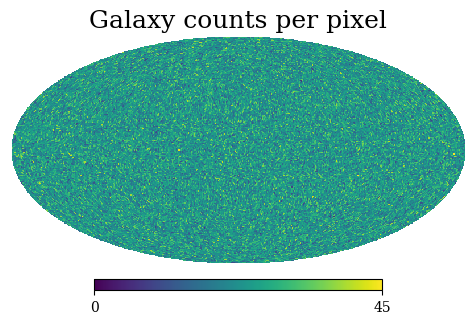

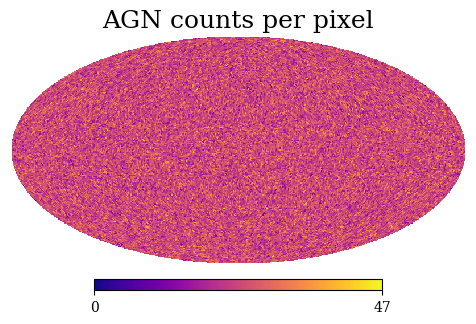

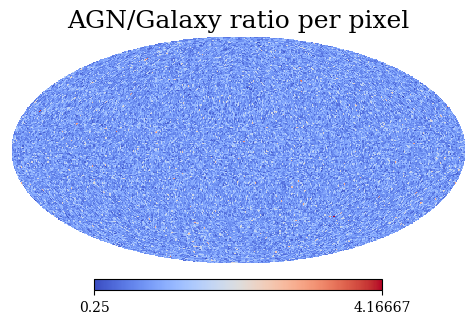

In [20]:
# Create sky maps - each in its own row
npix = hp.nside2npix(nside)
gal_map = np.zeros(npix)
gal_map[:len(ngals)] = ngals
agn_map = np.zeros(npix)
agn_map[:len(nagns)] = nagns

# Ratio map
ratio_map = np.zeros(npix, dtype=float)
mask = ngals > 0
ratio_map[:len(mask)][mask] = nagns[mask] / ngals[mask]
ratio_map[:len(mask)][~mask] = np.nan

figsize = (6,3)

# Sky map 1: Galaxy counts
fig = plt.figure(figsize=figsize)
hp.mollview(gal_map, title='Galaxy counts per pixel', cmap='viridis', 
            min=0, max=ngals.max(), fig=fig)
plt.title('Galaxy counts per pixel', fontsize=18)
plt.show()

# Sky map 2: AGN counts
fig = plt.figure(figsize=figsize)
hp.mollview(agn_map, title='AGN counts per pixel', cmap='plasma', 
            min=0, max=nagns.max(), fig=fig)
plt.title('AGN counts per pixel', fontsize=18)
plt.show()

# Sky map 3: AGN/Galaxy ratio
fig = plt.figure(figsize=figsize)
hp.mollview(ratio_map, title='AGN/Galaxy ratio per pixel', cmap='coolwarm', 
            fig=fig)
plt.title('AGN/Galaxy ratio per pixel', fontsize=18)
plt.show()

## Compute and Plot Likelihood Grid


In [28]:
# Set up paths and parameters for loading likelihood grid
import sys
import os
sys.path.append('../code')

# Define file paths (same parameters as main inference)
ratioNgalNagn = 1
bias_gal = 1.0
bias_agn = 1.0
f_agn = 0.5
lambda_agn = 0.5
N_gw = 1000
seed = 42
gw_seed = 1042
nside = 64

tag_mock_extra = f'_bgal{bias_gal}_bagn{bias_agn}'
tag_mock = f'_seed{seed}_ratioNgalNagn{ratioNgalNagn}{tag_mock_extra}'
tag_inf = f'_fagn{f_agn}_lambdaagn{lambda_agn}_N{N_gw}_seed{gw_seed}'

# Path to saved likelihood grid (from run_inference.py with mode='likelihood_grid')
likelihood_grid_file = f'../results/inference/likelihood_grid{tag_inf}.h5'

print(f"Loading likelihood grid from: {likelihood_grid_file}")


Loading likelihood grid from: ../results/inference/likelihood_grid_fagn0.5_lambdaagn0.5_N1000_seed1042.h5


In [29]:
# Load likelihood grid from saved file
print("Loading likelihood grid...")
likelihood_results = load_likelihood_grid(likelihood_grid_file)

# Extract data from loaded results
log_likelihood_grid = likelihood_results['log_likelihood_grid']
H0_grid = likelihood_results['H0_grid']
f_grid = likelihood_results['f_grid']
config = likelihood_results.get('config', {})
metadata = likelihood_results.get('metadata', {})
grid_params = likelihood_results.get('grid_params', {})

# Get parameters from config/metadata if available
N_gw = config.get('nEvents', metadata.get('nEvents', N_gw))
nside = config.get('nside', metadata.get('nside', nside))

print(f"Loaded likelihood grid with shape: {log_likelihood_grid.shape}")
print(f"H0 grid: {len(H0_grid)} points from {H0_grid.min():.1f} to {H0_grid.max():.1f}")
print(f"f grid: {len(f_grid)} points from {f_grid.min():.3f} to {f_grid.max():.3f}")
if grid_params:
    print(f"Grid parameters: Om0={grid_params.get('Om0', 'N/A')}, "
          f"gamma_agn={grid_params.get('gamma_agn', 'N/A')}, "
          f"gamma_gal={grid_params.get('gamma_gal', 'N/A')}")

# Note: The saved grid has shape (n_H0, n_f), but plotting code expects (n_f, n_H0)
# Transpose to match the expected convention for plotting
if log_likelihood_grid.shape[0] == len(H0_grid) and log_likelihood_grid.shape[1] == len(f_grid):
    log_likelihood_grid = log_likelihood_grid.T  # Transpose to (n_f, n_H0)
    print(f"Transposed grid to shape: {log_likelihood_grid.shape} for plotting")

# Create meshgrid for plotting
H0_mesh, f_mesh = np.meshgrid(H0_grid, f_grid)


Loading likelihood grid...
Loading likelihood grid from ../results/inference/likelihood_grid_fagn0.5_lambdaagn0.5_N1000_seed1042.h5
Loaded likelihood grid with shape: (20, 20)
H0 grid: 20 points from 50.0 to 100.0
f grid: 20 points from 0.000 to 1.000
Grid parameters: Om0=None, gamma_agn=0, gamma_gal=0
Transposed grid to shape: (20, 20) for plotting


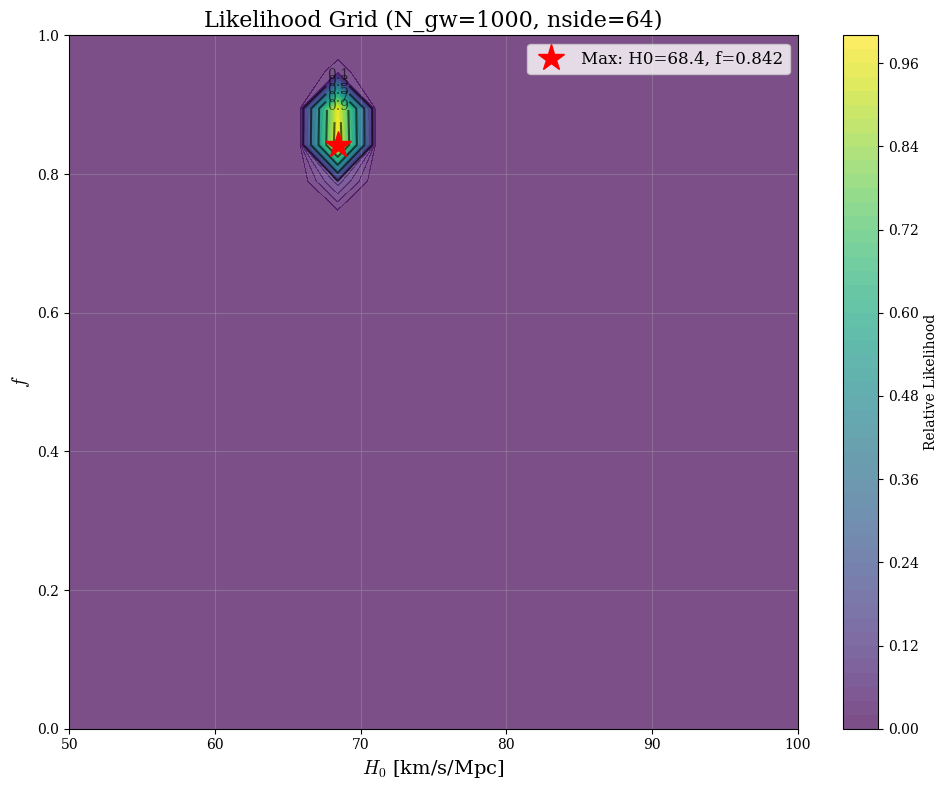

In [30]:
# Plot likelihood grid as contour plot
fig, ax = plt.subplots(figsize=(10, 8))

# Convert to likelihood (relative, normalized)
likelihood_grid = np.exp(log_likelihood_grid - np.nanmax(log_likelihood_grid))

# Create contour plot
contour_levels = [0.1, 0.3, 0.5, 0.7, 0.9]
CS = ax.contour(H0_mesh, f_mesh, likelihood_grid, levels=contour_levels, 
                colors='black', alpha=0.6, linewidths=1.5)
ax.clabel(CS, inline=True, fontsize=10, fmt='%.1f')

# Fill contours
im = ax.contourf(H0_mesh, f_mesh, likelihood_grid, levels=50, cmap='viridis', alpha=0.7)
plt.colorbar(im, ax=ax, label='Relative Likelihood')

# Mark maximum
max_idx = np.unravel_index(np.nanargmax(log_likelihood_grid), log_likelihood_grid.shape)
H0_max_val = H0_grid[max_idx[1]]
f_max_val = f_grid[max_idx[0]]
ax.plot(H0_max_val, f_max_val, 'r*', markersize=20, label=f'Max: H0={H0_max_val:.1f}, f={f_max_val:.3f}')

ax.set_xlabel(r'$H_0$ [km/s/Mpc]', fontsize=14)
ax.set_ylabel(r'$f$', fontsize=14)
ax.set_title(f'Likelihood Grid (N_gw={N_gw}, nside={nside})', fontsize=16)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


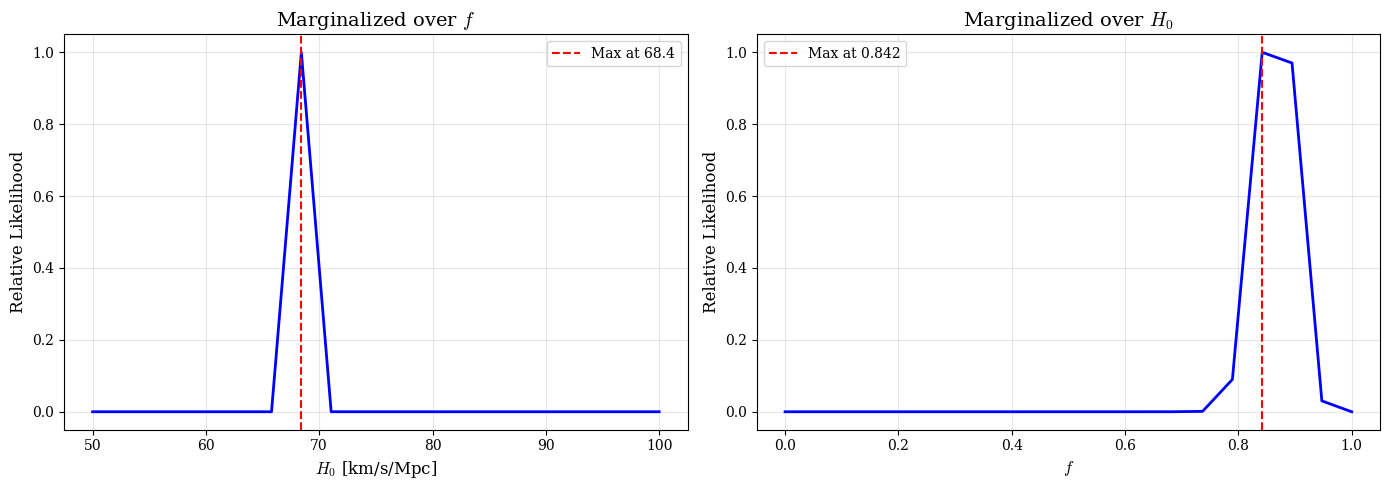

In [31]:
# Plot 1D marginal likelihoods
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Marginalize over f to get H0 likelihood
H0_likelihood = np.nansum(likelihood_grid, axis=0)
H0_likelihood = H0_likelihood / np.nanmax(H0_likelihood)

axes[0].plot(H0_grid, H0_likelihood, 'b-', linewidth=2)
axes[0].axvline(H0_max_val, color='r', linestyle='--', label=f'Max at {H0_max_val:.1f}')
axes[0].set_xlabel(r'$H_0$ [km/s/Mpc]', fontsize=12)
axes[0].set_ylabel('Relative Likelihood', fontsize=12)
axes[0].set_title('Marginalized over $f$', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Marginalize over H0 to get f likelihood
f_likelihood = np.nansum(likelihood_grid, axis=1)
f_likelihood = f_likelihood / np.nanmax(f_likelihood)

axes[1].plot(f_grid, f_likelihood, 'b-', linewidth=2)
axes[1].axvline(f_max_val, color='r', linestyle='--', label=f'Max at {f_max_val:.3f}')
axes[1].set_xlabel(r'$f$', fontsize=12)
axes[1].set_ylabel('Relative Likelihood', fontsize=12)
axes[1].set_title('Marginalized over $H_0$', fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Setup and Load inference results

In [26]:
# Define inference results path
ratioNgalNagn = 1
bias_gal = 1.0
bias_agn = 1.0
f_agn = 0.5
lambda_agn = 0.5
N_gw = 1000
seed = 42
gw_seed = 1042

tag_inf = f'_fagn{f_agn}_lambdaagn{lambda_agn}_N{N_gw}_seed{gw_seed}'
output_file = f'../results/inference/inference_results{tag_inf}.h5'


In [27]:
loaded_results = load_inference_results(output_file)
print_inference_summary(loaded_results)

# Load truth values
# Truth values from mock generation parameters
truth_f_agn = f_agn  # f_agn = 0.5 is the true AGN fraction parameter
truth_f = truth_f_agn  # The inferred parameter f corresponds to f_agn
truth_H0 = loaded_results['metadata'].get('H0Planck', 67.74)  # Use H0Planck as truth value

print(f"\nTruth values:")
print(f"  H0 (truth): {truth_H0:.2f} km/s/Mpc")
print(f"  f (truth): {truth_f:.3f}")


Loading inference results from ../results/inference/inference_results_fagn0.5_lambdaagn0.5_N1000_seed1042.h5
Printing inference results summary
Inference Results Summary
Timestamp: 2025-11-26T13:16:47.297788
Number of samples: 12800
Number of parameters: 2

MCMC Parameters:
  $H_0$: [20, 120]
  $f$: [0, 1]

Configuration:
  galaxy_file: ../data/mocks_glass/mock_seed42_ratioNgalNagn1_bgal1.0_bagn1.0/lognormal_pixelated_nside_64_galaxies.h5
  agn_file: ../data/mocks_glass/mock_seed42_ratioNgalNagn1_bgal1.0_bagn1.0/lognormal_pixelated_nside_64_agn.h5
  gw_file: ../data/mocks_glass/mock_seed42_ratioNgalNagn1_bgal1.0_bagn1.0/gwsamples_fagn0.5_lambdaagn0.5_N1000_seed1042_pos_only.h5
  nside: 64
  nEvents: 100
  nsamp: 10000
  n_walkers: 16
  n_steps: 1000

Metadata:
  H0Planck: 67.74
  Om0Planck: 0.3075
  N_gal: 1176983.0
  N_agn: 1177354.0

Posterior Samples Shape: (12800, 2)
Parameter means:
  $H_0$: 66.7202 ± 5.4916
  $f$: 0.0406 ± 0.0840

Truth values:
  H0 (truth): 67.74 km/s/Mpc
  f (t

In [16]:
# Access data
samples = loaded_results['posterior_samples']
config = loaded_results['config']
metadata = loaded_results['metadata']
mcmc_params = loaded_results.get('mcmc_params', {})
labels = mcmc_params.get('labels', [f'param_{i}' for i in range(samples.shape[1])])

### Plot histograms

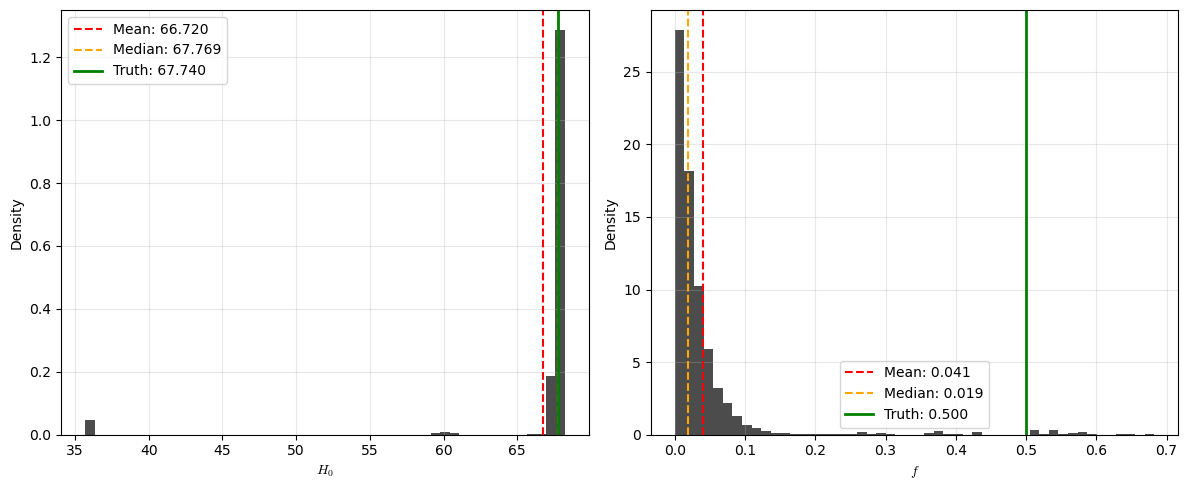

In [17]:
# Plot histograms for each parameter
n_params = samples.shape[1]
fig, axes = plt.subplots(1, n_params, figsize=(6*n_params, 5))

if n_params == 1:
    axes = [axes]

# Truth values array
truth_values = [truth_H0, truth_f]

for i, (ax, label) in enumerate(zip(axes, labels)):
    ax.hist(samples[:, i], bins=50, density=True, alpha=0.7, color='black')
    ax.axvline(np.mean(samples[:, i]), color='red', linestyle='--', 
               label=f'Mean: {np.mean(samples[:, i]):.3f}')
    ax.axvline(np.median(samples[:, i]), color='orange', linestyle='--', 
               label=f'Median: {np.median(samples[:, i]):.3f}')
    # Overplot truth value
    ax.axvline(truth_values[i], color='green', linestyle='-', linewidth=2,
               label=f'Truth: {truth_values[i]:.3f}')
    ax.set_xlabel(label)
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Corner plot


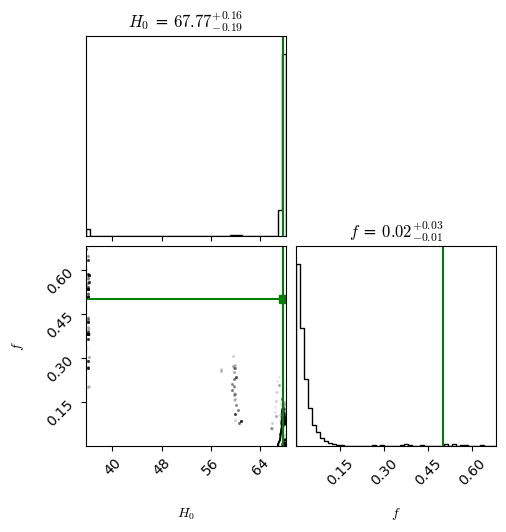

In [18]:
# Corner plot
import corner
fig = corner.corner(samples, labels=labels, show_titles=True, 
                    title_kwargs={"fontsize": 12}, bins=50,
                    truths=[truth_H0, truth_f], truth_color='green', 
                    truth_kwargs={'linestyle': '-', 'linewidth': 2})
plt.show()
